# 2. Retrieval Augmented Generation

In [1]:
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())

## 2.1 Document and Data Preprocessing

### 2.1.1 Preprocessing: PDF to Text Conversion

`pdfplumber`: Plumb a PDF for detailed information about each text character, rectangle, and line. Plus: Table extraction and visual debugging.

https://github.com/jsvine/pdfplumber

Several other Python libraries help users to extract information from PDFs. As a broad overview, pdfplumber distinguishes itself from other PDF processing libraries by combining these features:

* Easy access to detailed information about each PDF object
* Higher-level, customizable methods for extracting text and tables
* Tightly integrated visual debugging
* Other useful utility functions, such as filtering objects via a crop-box

It's also helpful to know what features pdfplumber does not provide:

* PDF generation
* PDF modification
* Optical character recognition (OCR)
* Strong support for extracting tables from OCR'ed documents

**Specific comparisons**

* `pdfminer.six` provides the foundation for pdfplumber. It primarily focuses on parsing PDFs, analyzing PDF layouts and object positioning, and extracting text. It does not provide tools for table extraction or visual debugging.
* `PyPDF2` is a pure-Python library "capable of splitting, merging, cropping, and transforming the pages of PDF files. It can also add custom data, viewing options, and passwords to PDF files." It can extract page text, but does not provide easy access to shape objects (rectangles, lines, etc.), table-extraction, or visually debugging tools.
* `pymupdf` is substantially faster than pdfminer.six (and thus also pdfplumber) and can generate and modify PDFs, but the library requires installation of non-Python software (MuPDF). It also does not enable easy access to shape objects (rectangles, lines, etc.), and does not provide table-extraction or visual debugging tools.
* `camelot`, `tabula-py`, and `pdftables` all focus primarily on extracting tables. In some cases, they may be better suited to the particular tables you are trying to extract.

In [2]:
import pdfplumber
from pathlib import Path

file_path = Path("fis_issue22-3.pdf").resolve()
pdf = pdfplumber.open(file_path)
pages = pdf.pages

page witdh x height = 595.276 x 841.89
[Extracted Text]
22-3호
FIS
2022.11.
ISSUE & FOCUS
발행인 박용주 발행처 04637 서울특별시 중구 퇴계로 10(남대문로5가 537) 메트로타워 T 02)6908-8200 F 02)6312-8959
작성 박정수 부연구위원, 우수연 연구원 기획·조정 심혜인 결산정보분석부장
재정융자사업
1 들어가며
2 재정융자사업의 개념과 의의
3 2023년도 예산안 재정융자사업 현황
4 재정융자사업의 주요 현안
5 나가며


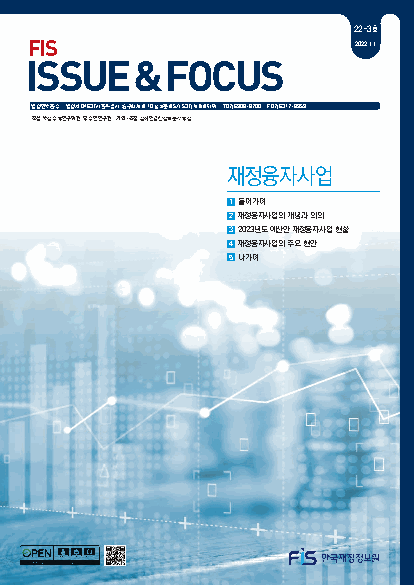

In [28]:
page = pages[0]
print(f'page witdh x height = {page.width} x {page.height}')
print('[Extracted Text]')
print(page.extract_text())
page.to_image(resolution=50)

page witdh x height = 1190.55 x 841.89


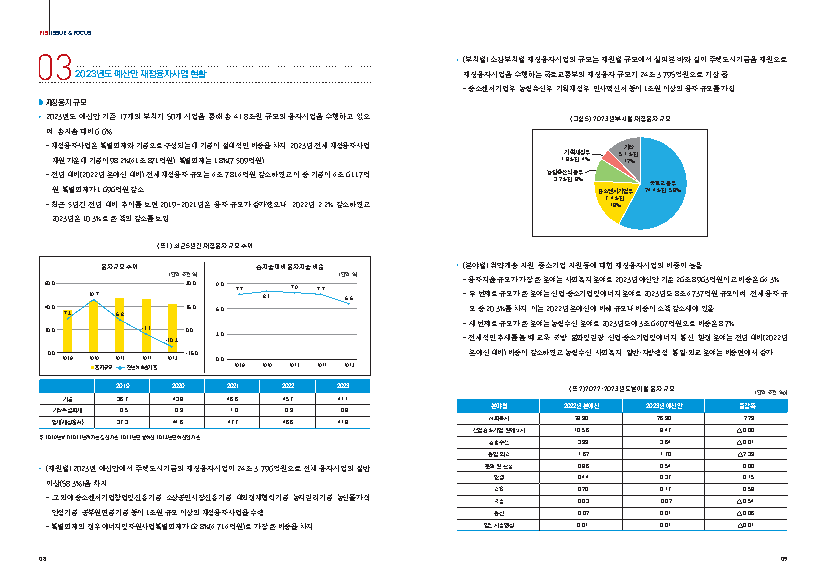

In [5]:
page = pages[4]
print(f'page witdh x height = {page.width} x {page.height}')
page.to_image(resolution=50)

Bounding box of `pdfplumber.page.Page` = (`x0`, `top`, `x1`, `bottom`). If `relative` is `True`:
* (`x0`, `top`) = (x, y) coordinates of the top-left corner of the box
* (`x1`, `bottom`) = (x, y) coordinates of the bottom-right corner of the box

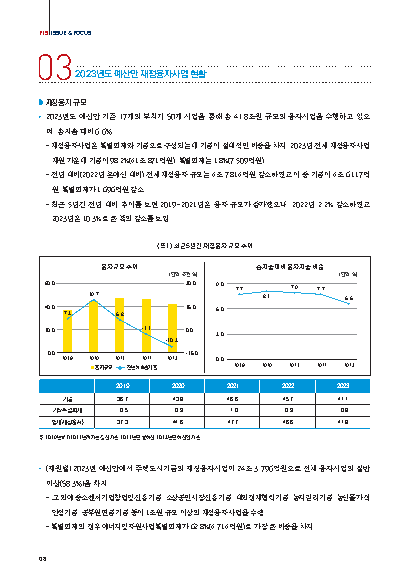

In [14]:
left = page.crop((0.0, 0.0, 0.5*page.width, page.height), relative=True, strict=True)
right = page.crop((0.5*page.width, 0.0, page.width, page.height), relative=True, strict=True)
left.to_image(resolution=50)

In [15]:
import re
# remove un used strings like 
def clean_text(s: str) -> str:
    # remove un used strings like 
    s = re.sub(r'[\x00-\x08\x0b\x0c\x0e-\x1f\x7f-\xff]', ' ', s)
    # if three white spaces or more(except '\n'), replace with empty string
    s = re.sub(r' {3,}', '', s)
    return s

print(clean_text(left.extract_text()))

FIS ISSUE & FOCUS
03
2023년도 예산안 재정융자사업 현황
재정융자 규모
 2023년도 예산안 기준 17개의 부처가 50개 사업을 통해 총 41.8조원 규모의 융자사업을 수행하고 있으
며, 총지출 대비 6.6%
- 재정융자사업은 특별회계와 기금으로 구성되는데 기금이 절대적인 비중을 차지. 2023년 전체 재정융자사업 
재원 가운데 기금이 98.2%(41조 871억원), 특별회계는 1.8%(7,509억원)
- 전년 대비(2022년 본예산 대비) 전체 재정융자 규모는 4조 7,814억원 감소하였고 이 중 기금이 4조 6,117억
원, 특별회계가 1,696억원 감소
- 최근 5년간 전년 대비 추이를 보면 2019~2021년은 융자 규모가 증가했으나, 2022년 2.2% 감소하였고 
2023년은 10.3%로 큰 폭의 감소를 보임
<표 1> 최근 5년간 재정융자 규모 추이
융자 규모 추이 총지출 대비 융자지출 비중
(단위: 조원,%) (단위: %)
60.0 30.0 9.0
7.7 7.9 7.7
19.7 8.1
6.6
40.0 15.0
6.0
7.3 6.8
20.0 -2.2 0.0
3.0
-10.3
0.0 -15.0
2019 2020 2021 2022 2023 0.0
2019 2020 2021 2022 2023
융자규모 전년대비증가율
2019 2020 2021 2022 2023
기금 36.7 43.8 46.6 45.7 41.1
기타특별회계 0.5 0.9 1.0 0.9 0.8
합계(재정융자) 37.3 44.6 47.7 46.6 41.8
주: 2019년부터 2021년까지는 결산 기준, 2022년은 본예산, 2023년은 예산안 기준.
 (재원별) 2023년 예산안에서 주택도시기금의 재정융자사업이 24조 3,796억원으로 전체 융자사업의 절반 
이상(58.3%)을 차지
- 그 외에 중소벤처기업창업및진흥기금, 소상공인시장진흥기금, 대외경제협력기금, 농지관리기금, 농산물가격
안정기금, 공무원연금기금 등이 1조원 규모 이상의 재정융자사업을 수행
- 특별회계의 경우 에

`Layout-Parser` is a unified toolkit for deep learning based document image analysis

* https://layout-parser.github.io
* https://github.com/Layout-Parser/layout-parser
* https://github.com/Layout-Parser/layout-parser/blob/main/examples/Deep%20Layout%20Parsing.ipynb
* https://tesseract-ocr.github.io/tessdoc/Installation.html
* https://github.com/tesseract-ocr/tesseract
* https://yunwoong.tistory.com/51

The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


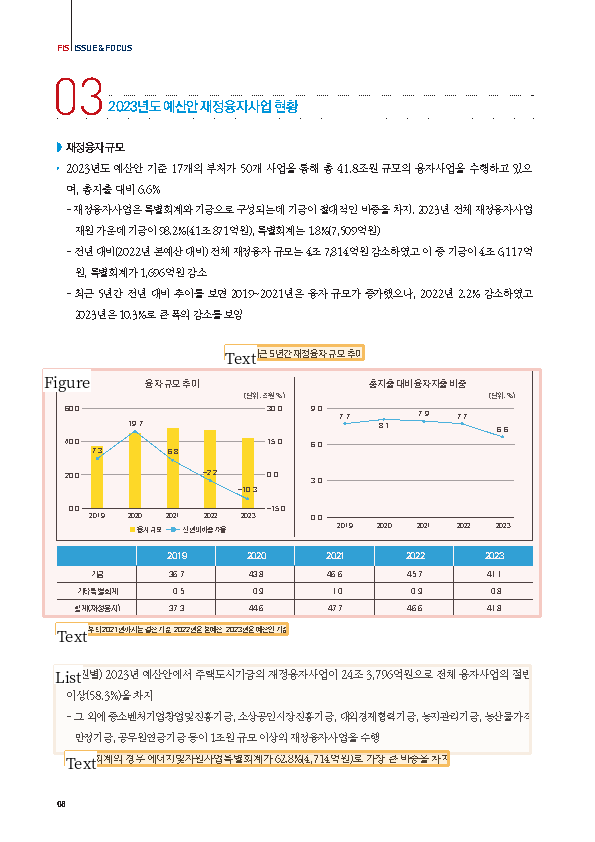

In [29]:
import numpy as np
import layoutparser as lp
import torchvision.ops.boxes as bops
from io import BytesIO
from PIL import Image
from pdfplumber.page import Page, CroppedPage
from layoutparser.models.detectron2 import Detectron2LayoutModel

def inference_page(p: Page | CroppedPage, model: Detectron2LayoutModel) -> tuple:
    img = p.to_image()
    imgfile = BytesIO()
    img.save(imgfile, format='png', quantize=False)
    img = np.array(Image.open(imgfile).convert('RGB'))
    blocks = model.detect(img)
    return blocks, img

# lp://PubLayNet/faster_rcnn_R_50_FPN_3x/config
# lp://PubLayNet/mask_rcnn_X_101_32x8d_FPN_3x/config
model = Detectron2LayoutModel(
    'lp://PubLayNet/mask_rcnn_X_101_32x8d_FPN_3x/config', 
    extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.8],
    label_map={0: "Text", 1: "Title", 2: "List", 3: "Table", 4: "Figure"}
)

# using deep learning model to detect the layout of figures
blocks, img = inference_page(left, model)
lp.draw_box(img, blocks, box_width=3, box_alpha=0.2, show_element_type=True)

It returns the coordinates of (`x_0`, `y_0`, `x_1`, `y_1`) for each text box in the PDF.

Coordinates of the first block:
x1: 43.5514, y1: 369.6765
x2: 540.5313, y2: 616.0615


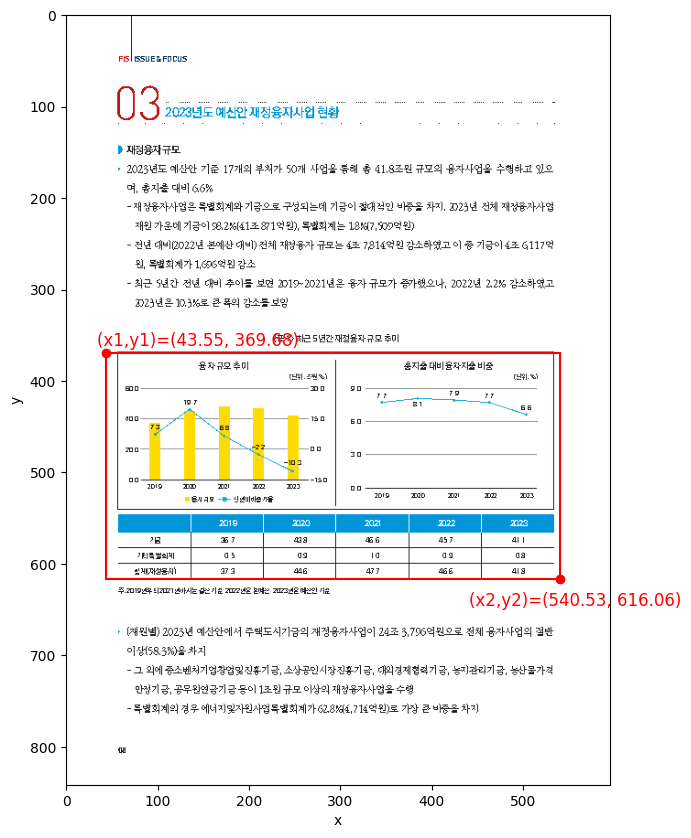

In [30]:
import matplotlib.pyplot as plt

def draw_block_with_coords(block, img):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.imshow(img)
    # draw bounding box of the first block on the img
    ax.add_patch(plt.Rectangle(
    (block.x_1, block.y_1),   # x, y
    block.x_2 - block.x_1,  # width
    block.y_2 - block.y_1,  # height
    fill=False, edgecolor='red', lw=1.5))
    # draw the red dot at the top-left corner of the bounding box
    ax.plot(block.x_1, block.y_1, 'ro')
    # draw the red dot at the bottom-right corner of the bounding box
    ax.plot(block.x_2, block.y_2, 'ro')
    # write the coordinates
    ax.text(block.x_1 - 10, block.y_1 - 8.5, 
            f'(x1,y1)=({block.x_1:.2f}, {block.y_1:.2f})', 
            fontsize=12, color='red')
    ax.text(block.x_2 - 100, block.y_2 + 30, 
            f'(x2,y2)=({block.x_2:.2f}, {block.y_2:.2f})', 
            fontsize=12, color='red')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.show()

block = blocks[0].block
print(f'Coordinates of the first block:')
print(f'x1: {block.x_1:.4f}, y1: {block.y_1:.4f}')
print(f'x2: {block.x_2:.4f}, y2: {block.y_2:.4f}')

draw_block_with_coords(block, img)

In [348]:
# store all the pdf pages for further usage
PDF_PAGES = []
for page in pages:
    if page.height > page.width:
        PDF_PAGES.append(page)
    else:
        left = page.crop((0.0, 0.0, 0.5*page.width, page.height), relative=True, strict=True)
        right = page.crop((0.5*page.width, 0.0, page.width, page.height), relative=True, strict=True)
        PDF_PAGES.append(left)
        PDF_PAGES.append(right)

### 2.1.2 Load Documents 

`Document` is a basic class of object to represent a piece of information. 

* `page_content`, `metadata`

In [121]:
import json
from langchain_core.documents import Document

doc = Document(
    page_content='I am a page content',
    metadata = {'page': 0}
)
doc.__dict__

{'id': None,
 'metadata': {'page': 0},
 'page_content': 'I am a page content',
 'type': 'Document'}

In [123]:
with open('./fis_issue22_3.json', 'r') as f:
    all_data = json.load(f)

docs = []
for data in all_data:
    doc = Document(
        page_content = data['page_content'],
        metadata = data['metadata']
    )
    docs.append(doc)

print(docs[0].page_content)
print(f'\nTotal Documents: {len(docs)}')

22-3호
FIS
2022.11.
ISSUE & FOCUS
발행인 박용주 발행처 04637 서울특별시 중구 퇴계로 10(남대문로5가 537) 메트로타워 T 02)6908-8200 F 02)6312-8959
작성 박정수 부연구위원, 우수연 연구원 기획·조정 심혜인 결산정보분석부장
재정융자사업
1 들어가며
2 재정융자사업의 개념과 의의
3 2023년도 예산안 재정융자사업 현황
4 재정융자사업의 주요 현안
5 나가며

Total Documents: 16


### 2.1.3 Text Splitter

Benefits for splitting documents:

* **Efficient resouce management**: Inputting an entire document into an LLM is costly and hinders efficient answer extraction from extensive information, sometimes causing hallucination issues. Therefore, the aim is to extract only the information needed for the response.
* **Accurate information retrieval**: Segmenting documents aids in extracting only the relevant information for a given query. By focusing on specific topics or content within each segment, it ensures the retrieval of highly pertinent information.

At a high level, text splitters work as following:

1. Split the text up into small, semantically meaningful chunks (often sentences).
2. Start combining these small chunks into a larger chunk until you reach a certain size (as measured by some function).
3. Once you reach that size, make that chunk its own piece of text and then start creating a new chunk of text with some overlap (to keep context between chunks).

That means there are two different axes along which you can customize your text splitter:

1. How the text is split
2. How the chunk size is measured

In [162]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    # the maximum size of the split text chunks.
    chunk_size=250,
    # the number of overlapping characters between split text chunks.
    chunk_overlap=0,
    # the function to calculate the length of the text.
    length_function=len,
    # whether the delimiter is a regular expression.
    is_separator_regex=False,
    
)

texts = []
metadatas = []
for data in all_data:
    texts.append(data['page_content'])
    metadatas.append(data['metadata'])
documents = text_splitter.create_documents(texts, metadatas)

print(f'Original number of pages: {len(all_data)}')
print(f'Total Documents: {len(documents)}')

Original number of pages: 16
Total Documents: 71


`RecursiveCharacterTextSplitter` is designed for general text and operates by using a specified list of characters as parameters. It splits the text in the order of the provided characters until the resulting chunks are small enough. By default, it uses the characters `["\n\n", "\n", " ", ""]`, splitting the text recursively from paragraphs to sentences to words.

In [156]:
print(all_data[4]['page_content'])

<그림 1> 특별회계 재정융자 제도 발전

자료: 한국재정정보원, 2019.
 기금융자제도의 발전
- (개시) 1973년 농수산물가격안정기금, 관광진흥기금, 1974년 국민투자기금 융자사업을 시작 
- (확대) 1977년 5개, 1980년 9개, 1985년 12개, 1992년 16개 등 융자사업을 운영하는 기금의 수(당해연도 지
출액 기준)는 매년 증가3)
 융자 규모의 변화
- 다기한 재정융자 현황을 파악하고 특별회계, 기금제도의 변천 정리, 향후 개선 방향을 제시하기 위해 
발간한 「재정투융자백서」에 의하면, 정부의 재정융자사업 규모는 지속적으로 증가
<그림 2> 1993년 이전의 재정융자사업 추이
(단위: 백만원, %)

자료: 재정투융자백서(1983, 1989, 1993).
2)개 발시기 융자의 집행은 특별회계 중심의 재정융자제도 운영, 여유자금을 활용한 기금 융자, 외국으로부터 도입한 차관자금의 활용(정부차관 자금의 전대는
세입 세출외로 운영) 등 3가지임.
3)초 기 국민투자기금의 중화학공업 육성을 위한 재원 마련 증가, 이후 주택건설 등 개별 정책 목적의 재정융자가 크게 증가하여 특별회계의 차관 및 일반회계 잉여금 위주의
재정융자 규모를 압도함. 예를 들어 1982년 국민주택기금(현 주택도시기금) 융자 규모는 국민투자기금의 1/3, 전체 기금 융자의 1/5 수준이었으나 1993년
국민투자기금은 폐지, 국민주택기금 융자 규모는 전체 기금 융자의 1/2 수준으로 확대됨.
05


In [164]:
split_documents = [d for d in documents if d.metadata['page'] == 4]
for i, sd in enumerate(split_documents):
    print(f'\n[Split Documents for Page 4] - {i+1}')
    print(sd.page_content)


[Split Documents for Page 4] - 1
<그림 1> 특별회계 재정융자 제도 발전

[Split Documents for Page 4] - 2
자료: 한국재정정보원, 2019.
 기금융자제도의 발전
- (개시) 1973년 농수산물가격안정기금, 관광진흥기금, 1974년 국민투자기금 융자사업을 시작 
- (확대) 1977년 5개, 1980년 9개, 1985년 12개, 1992년 16개 등 융자사업을 운영하는 기금의 수(당해연도 지
출액 기준)는 매년 증가3)
 융자 규모의 변화
- 다기한 재정융자 현황을 파악하고 특별회계, 기금제도의 변천 정리, 향후 개선 방향을 제시하기 위해

[Split Documents for Page 4] - 3
발간한 「재정투융자백서」에 의하면, 정부의 재정융자사업 규모는 지속적으로 증가
<그림 2> 1993년 이전의 재정융자사업 추이
(단위: 백만원, %)

[Split Documents for Page 4] - 4
자료: 재정투융자백서(1983, 1989, 1993).
2)개 발시기 융자의 집행은 특별회계 중심의 재정융자제도 운영, 여유자금을 활용한 기금 융자, 외국으로부터 도입한 차관자금의 활용(정부차관 자금의 전대는
세입 세출외로 운영) 등 3가지임.
3)초 기 국민투자기금의 중화학공업 육성을 위한 재원 마련 증가, 이후 주택건설 등 개별 정책 목적의 재정융자가 크게 증가하여 특별회계의 차관 및 일반회계 잉여금 위주의

[Split Documents for Page 4] - 5
재정융자 규모를 압도함. 예를 들어 1982년 국민주택기금(현 주택도시기금) 융자 규모는 국민투자기금의 1/3, 전체 기금 융자의 1/5 수준이었으나 1993년
국민투자기금은 폐지, 국민주택기금 융자 규모는 전체 기금 융자의 1/2 수준으로 확대됨.
05


## 2.2 Embeddings 

Embedding models create a vector representation of a piece of text that captures the semantic meaning of the text.

In [180]:
import os
import numpy as np
import matplotlib.pyplot as plt
from langchain_openai import OpenAIEmbeddings
from langchain_huggingface.embeddings import HuggingFaceEmbeddings

openai_embeddings = OpenAIEmbeddings(
    api_key = os.getenv('OPENAI_API_KEY'),
    model = 'text-embedding-3-small', # text-embedding-ada-002
    dimensions = 1024  # 1536 for text-embedding-ada-002
)

model_name = 'intfloat/multilingual-e5-large-instruct'
hf_embeddings = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs={'device': 'cpu'},  # cuda, cpu
    encode_kwargs={'normalize_embeddings': True},
)

Similarity calculation

* `Cosine similarity` is a measure of similarity between two non-zero vectors of an inner product space that measures the cosine of the angle between them. It is thus a judgment of orientation and not magnitude: two vectors with the same orientation have a cosine similarity of 1, two vectors at 90° have a similarity of 0, and two vectors diametrically opposed have a similarity of -1, independent of their magnitude.

$$\text{cosine\_similarity}(\mathbf{a}, \mathbf{b}) = \frac{\mathbf{a} \cdot \mathbf{b}}{\vert\mathbf{a}\vert \vert\mathbf{b}\vert} = \frac{\sum_{i=1}^{n} a_i b_i}{\sqrt{\sum_{i=1}^{n} a_i^2} \sqrt{\sum_{i=1}^{n} b_i^2}}$$



In [182]:
# embed the text into a vector 
e1_en = np.array(openai_embeddings.embed_query('Hello, world!'))
e1_kr = np.array(openai_embeddings.embed_query('안녕하세요, 세계!'))
e2_en = np.array(hf_embeddings.embed_query('Hello, world!'))
e2_kr = np.array(hf_embeddings.embed_query('안녕하세요, 세계!'))

# they are not quite similar since it is mostly trained on English
print(f'OpenAI Similarity: {e1_en @ e1_kr: .4f}')
# they are similar since it is trained on multi-lingual
print(f'HuggingFace Similarity: {e2_en @ e2_kr: .4f}')
# they are not similar, since they are trained on different models
print(f'Two Embeddings Similarity: {e1_en @ e2_en: .4f}')

OpenAI Similarity:  0.5821
HuggingFace Similarity:  0.9322
Two Embeddings Similarity: -0.0321


visualize embeddings

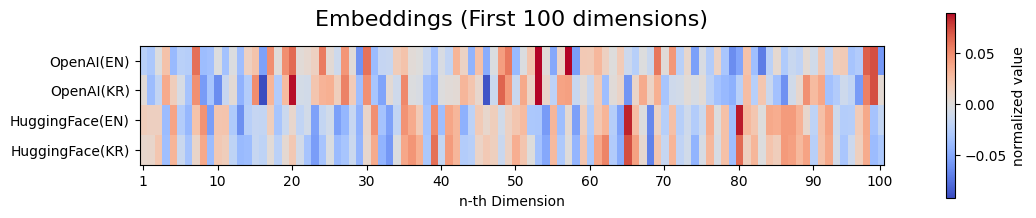

In [290]:
# visualize the embeddings
n = 100
fig, ax = plt.subplots(1, 1, figsize=(16, 6), sharex=True)
es = np.array([e1_en, e1_kr, e2_en, e2_kr])[:, :n]
titles = ['OpenAI(EN)', 'OpenAI(KR)','HuggingFace(EN)', 'HuggingFace(KR)']
m = ax.matshow(es, cmap='coolwarm', interpolation='nearest', aspect=4)
ax.set_yticks(np.arange(len(titles)))
ax.set_yticklabels(titles)
ax.set_title('Embeddings (First 100 dimensions)', y=1.1, fontsize=16)
ax.set_xticks(list(range(0, n, 10))+[n-1])
ax.set_xticklabels([1] + list(range(10, n, 10))+[n])
ax.set_xlabel('n-th Dimension')
plt.gca().xaxis.tick_bottom()
plt.colorbar(m, orientation='vertical', fraction=0.35, shrink=0.40, pad=0.05, label='normalized value', ax=ax)
plt.show()

## 2.3 Vector Store and Retriever

A vector store takes care of storing embedded data and performing vector searches.

In [299]:
# FAISS 
from langchain_community.vectorstores import FAISS

faiss_db = FAISS.from_documents(
    documents,     # embedding documents
    hf_embeddings  # embedding model
)


`FAISS` is a library for efficient similarity search and clustering of dense vectors. It contains algorithms that search in sets of vectors of any size, up to ones that possibly do not fit in RAM. It also contains supporting code for evaluation and parameter tuning. FAISS is written in C++ with complete wrappers for Python/numpy. Some of the most useful algorithms are implemented on the GPU. It is developed by Facebook AI Research.

* https://github.com/facebookresearch/faiss

In [343]:
# similarity search with vector store
similar_docs = faiss_db.similarity_search('재정 융자사업의 개념은 무엇인가요?', k=3)

# returns the list of similar documents with the score(L2 distance)
similar_docs = faiss_db.similarity_search_with_score('재정융자 사업의 개념은 무엇인가요?', k=3)

print('[Search Results]')
for i, (doc, score) in enumerate(similar_docs):
    print(f'Document {i}(s={score:.4f}) - Page: {doc.metadata["page"]}')
    print(f'{doc.page_content}\n')

[Search Results]
Document 0(s=0.1898) - Page: 2
02
재정융자사업의 개념과 의의
재정융자사업의 개념
 재정융자사업은 민간부문의 경제활동 역량을 강화하거나 지원하는 실효성 있는 강력한 정부 활동에 해당
- (정의) 재정융자는 정부가 민간의 사적 경제주체에 대해 금융적 성격으로 대출해 주는 것을 의미
 재정융자사업은 법적 측면에서 재정융자제도라고도 하며, 정책자금, 정책사업으로 구분하기도 함

Document 1(s=0.2140) - Page: 2
재정융자사업의 금융적 성격으로 인해, 다른 재정지원 방식과 달리 융자금 회수와 순융자 성격을 가짐
- (재정융자의 금융적 성격) 금융 성격의 재정이란 금융시장에서 금융상품을 거래하는 방식으로 정부의 수입과 
지출활동이 수행된다는 것을 의미1) 
- (재원조달) 재정융자의 재원은 국세 또는 세외수입 등 경상수입의 일부, 기금의 여유자금, 외국으로부터의 
차관 등으로 조달

Document 2(s=0.2188) - Page: 3
FIS ISSUE & FOCUS
국민경제에서 재정융자사업의 역할
 재정융자사업은 국민경제에 큰 영향을 미치는 활동으로, 다양한 역할을 수행
- (투자 역할) 주택 건설, 도로 댐 항만 등 사회간접자본의 확충, 농수산업 육성 등 경제개발을 위한 투자 역할을 
수행하며, 특히 개발도상국에서 경제성장을 위한 기초를 조성하는 데 중요한 역할을 담당



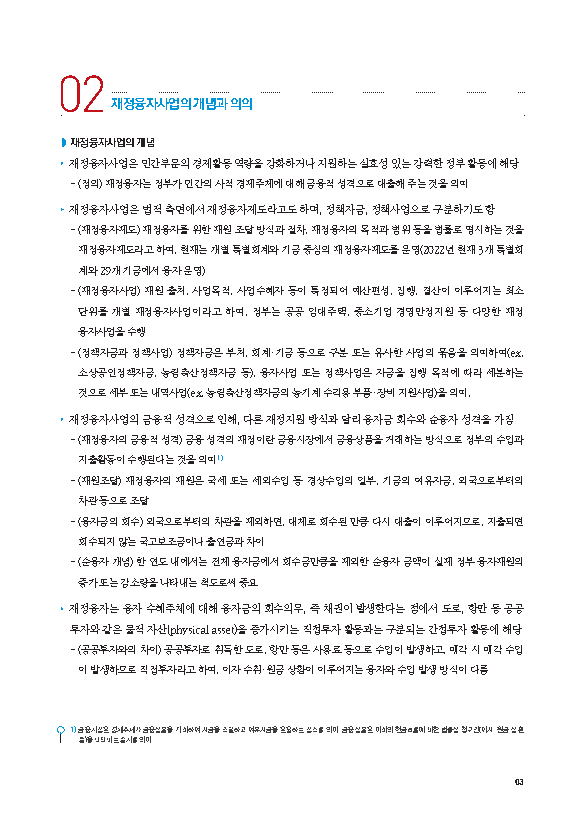

In [350]:
PDF_PAGES[2].to_image(resolution=70)

In [353]:
# filter the documents with the metadata
similar_docs = faiss_db.similarity_search_with_score(
    '재정융자 사업의 개념은 무엇인가요?', k=3, filter=dict(page=10)
)

print('[Search Results]')
for i, (doc, score) in enumerate(similar_docs):
    print(f'Document {i}(s={score:.4f}) - Page: {doc.metadata["page"]}')
    print(f'{doc.page_content}\n')

[Search Results]


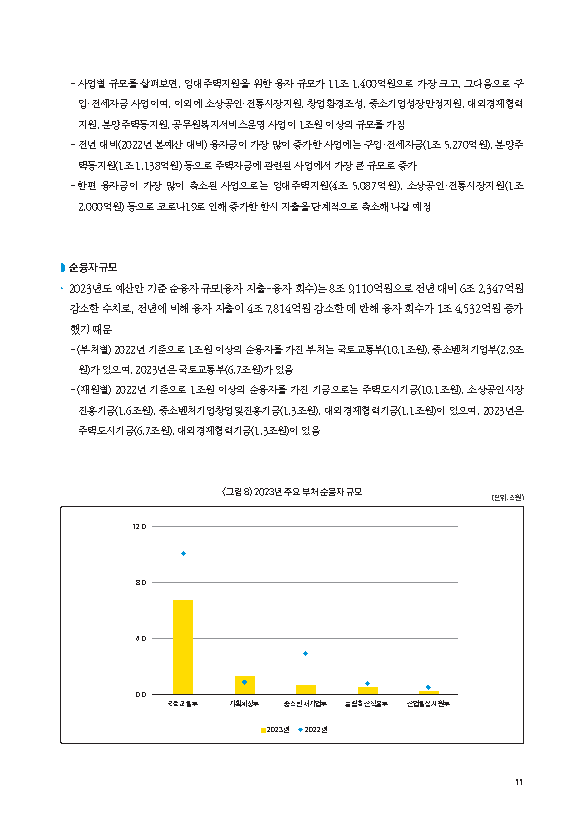

In [352]:
PDF_PAGES[10].to_image(resolution=70)

A retriever is an interface that returns documents given an unstructured query. It is more general than a vector store. 

The `MMR (Maximal Marginal Relevance)` method avoids redundancy in query results by balancing relevance and diversity. Instead of retrieving only the most relevant items, MMR ensures that the results include diverse perspectives and new information, preventing the selection of very similar items. This approach helps users gain a broader understanding of a topic by considering both the relevance of documents to the query and their dissimilarity from already selected documents.

In [337]:
# similarity search with retriever
# we can use LCEL style query
retriever = faiss_db.as_retriever(
    search_type = 'mmr',    # "similarity", "mmr", or "similarity_score_threshold".
    search_kwargs={'k': 3}  # {"score_threshold": 0.75}
)
similar_docs = retriever.invoke('재정 융자사업의 개념은 무엇인가요?')
print('[Search Results]')
for i, doc in enumerate(similar_docs):
    print(f'Document {i}(s={score:.4f}) - Page: {doc.metadata["page"]}')
    print(f'{doc.page_content}\n')

[Search Results]
Document 0(s=0.2188) - Page: 2
02
재정융자사업의 개념과 의의
재정융자사업의 개념
 재정융자사업은 민간부문의 경제활동 역량을 강화하거나 지원하는 실효성 있는 강력한 정부 활동에 해당
- (정의) 재정융자는 정부가 민간의 사적 경제주체에 대해 금융적 성격으로 대출해 주는 것을 의미
 재정융자사업은 법적 측면에서 재정융자제도라고도 하며, 정책자금, 정책사업으로 구분하기도 함

Document 1(s=0.2188) - Page: 4
<그림 1> 특별회계 재정융자 제도 발전

Document 2(s=0.2188) - Page: 2
1)금 융시장은 경제주체가 금융상품을 거래하여 자금을 조달하고 여유자금을 운용하는 장소를 의미. 금융상품은 미래의 현금흐름에 대한 법률상 청구권(이자, 원금 상환
등)을 나타내는 증서를 의미.
03



There are also other retriever classes, such as `EnsembleRetriever`, `SelfQueryRetriever`

* `EnsembleRetriever`: An ensemble of retrievers that aggregates their results.
* `SelfQueryRetriever`: A retriever that generate question by itself with LLM.

## 2.4 Naive Retrieval Augmented Generation

<img src="https://lh3.googleusercontent.com/d/1J7JasPNjGfAySxvZoqG7aV29F1nYuxXQ" width="75%">

1. **Indexing**: Documents are split into chunks, encoded into vectors, and stored in a vector database. (Relevant to `VectorStore`)
2. **Retrieval**: Retrieve the Top k chunks most relevant to the question based on semantic similarity. (Relevant to `Retriever`)
3. **Generation**: Input the original question and the retrieved chunks together into LLM to generate the final answer. (Relevant to `LCEL pipeline`)

### 2.4.1 Step 1: Load data

In [2]:
import json
from langchain_core.documents import Document

with open('./fis_issue22_3.json', 'r') as f:
    all_data = json.load(f)

### 2.4.2 Step 2: Split documents

In [3]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=300, chunk_overlap=50, length_function=len,
)

texts = []
for data in all_data:
    texts.append(data['page_content'])
texts = '\n\n'.join(texts)
documents = text_splitter.create_documents([texts])

print(f'Original number of pages: {len(all_data)}')
print(f'Total Documents: {len(documents)}')
print(texts.split('\n\n')[1][:767])

Original number of pages: 16
Total Documents: 59
FIS ISSUE & FOCUS
정부는 지난 8월 ‘따뜻한 나라, 역동적 경제, 건전한 재정’을 목표로 하는
재정융자사업
2023년 예산안을 국회에 제출하였다. 올해 예산안은 새 정부의 첫 번째
편성안으로 건전재정으로의 재정기조 전환, 역대 최대 지출 재구조화 및
이에 기반을 둔 국정과제 핵심 정책과제 적극 이행 등의 내용을 담고 있다.
이 중 재정지출 재구조화에는 재정융자 축소 및 민간재원 조달 확대 방안도 담겨 있다. 코로나19 사태로 인한 기업 지원 등의 재정융
자 규모는 축소하고, 민간 조달이 가능한 고신용층 직접융자는 이차보전으로 전환하는 등 정부-민간 역할의 재정립을 통해 국민 부담
을 최소화하겠다는 것이다. 이처럼 재정융자사업은 환경 변화에 대응하는 대표적인 정부의 재량지출 수단으로 정부 수립 이후 지속
적으로 증가, 감소를 반복해 왔다. 이 글에서는 재정융자의 개념과 목적, 그리고 2023년 예산안에 나타난 정부의 재정융자사업
운영 방향에 대해 알아보도록 한다.
01
들어가며
ISSUE 왜 재정융자사업에 주목하는가?
 재정융자사업은 정부가 자금을 민간의 사적 경제주체에 대해 대출해 주고 회수하는 활동을 말하며, 정부
의 다양한 금융활동 중 직접대출과 전대 방식에 해당(재무부, 1993; 한국재정정보원, 2019)
- 정부의 금융활동은 직접융자 전대 외에도 금리 차액에 대한 보상(이차보전), 기업의 신용심사 및 보증(신용보
증) 등이 있으며, 재정융자사업은 이들과 비교해 민간 금융의 역할이 미약하거나 부족한 부분에 직접 자금을 
공급할 수


<img src="https://lh3.googleusercontent.com/d/1JCH8jNIWbWFyPb2bEaFkgMYrP1R5AB7w" width="50%">

visualize chunks: https://chunkviz.up.railway.app/

### 2.4.3 Step 3: Create embeddings and store them in a vector store

In [5]:
import os
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import FAISS

openai_embeddings = OpenAIEmbeddings(api_key = os.getenv('OPENAI_API_KEY'))
faiss_db = FAISS.from_documents(documents, openai_embeddings)

### 2.4.4 Step 4: Create a retriever

In [6]:
retriever = faiss_db.as_retriever(
    search_type='similarity_score_threshold',  # "similarity", "mmr", or "similarity_score_threshold".
    search_kwargs={'k': 3, 'score_threshold': 0.75}
)

similar_docs = retriever.invoke('재정 융자사업의 개념은 무엇인가요?')
print('[Search Results]')
for i, doc in enumerate(similar_docs):
    print(f'Document {i}')
    print(f'{doc.page_content}\n')

[Search Results]
Document 0
02
재정융자사업의 개념과 의의
재정융자사업의 개념
 재정융자사업은 민간부문의 경제활동 역량을 강화하거나 지원하는 실효성 있는 강력한 정부 활동에 해당
- (정의) 재정융자는 정부가 민간의 사적 경제주체에 대해 금융적 성격으로 대출해 주는 것을 의미
 재정융자사업은 법적 측면에서 재정융자제도라고도 하며, 정책자금, 정책사업으로 구분하기도 함
- (재정융자제도) 재정융자를 위한 재원 조달 방식과 절차, 재정융자의 목적과 범위 등을 법률로 명시하는 것을

Document 1
자 규모는 축소하고, 민간 조달이 가능한 고신용층 직접융자는 이차보전으로 전환하는 등 정부-민간 역할의 재정립을 통해 국민 부담
을 최소화하겠다는 것이다. 이처럼 재정융자사업은 환경 변화에 대응하는 대표적인 정부의 재량지출 수단으로 정부 수립 이후 지속
적으로 증가, 감소를 반복해 왔다. 이 글에서는 재정융자의 개념과 목적, 그리고 2023년 예산안에 나타난 정부의 재정융자사업
운영 방향에 대해 알아보도록 한다.
01
들어가며
ISSUE 왜 재정융자사업에 주목하는가?

Document 2
순융자 개념의 의미와 시기별 재정융자사업의 역할
- 경상지출, 자본(투자)지출과 정부의 금융 활동을 분리하고, 정부의 금융 활동을 융자금액 총액에서 회수금 총
액을 차감한 순융자로 정의하여, 순융자 금액이 전체 국가 경제에 어떠한 효과를 주었는가 밝히는 경제적 의
미의 분석을 가능하게 하도록 함 
<그림 3> 아래의 통합재정수지 및 순융자 추이를 보면, 통합재정수지가 큰 적자를 보일 때, 즉 지출이 수입 
규모를 앞서는 경기 후퇴기에 순융자 규모가 크게 늘어나고, 이후 융자 회수로 인하여 순융자가 (-)인 상태가



### 2.4.5 Step 5: Prompt Template

In [18]:
from langchain_core.prompts import PromptTemplate

template = '''You are an assistant for question-answering tasks. 
Use the following pieces of retrieved context to answer the question. 
When you answer the question you must quote the context number and the relevant text.
The output format should be a JSON object with the following structure:
```json
{{
    "context_id": "The retrieved context number(integer)",
    "quote": "The relevant text(part of the context)",
    "answer": "The answer to the question"
}}
```
Answer in Korean.

## Question:
{question}

## Context:
{context}

## Answer:
'''

prompt = PromptTemplate(
    template=template, 
    input_variables=['question', 'context']
)

### 2.4.6 Step 6: Define LLM

In [21]:
from langchain_openai import ChatOpenAI

model_openai = ChatOpenAI(
    model='gpt-4o-mini',  # latest model
    temperature=0.5,
    model_kwargs = {'response_format': {'type': 'json_object'}}
)

### 2.4.7 Step 7: Create Chain and Run

In [ ]:
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.output_parsers import JsonOutputParser
from langchain.pydantic_v1 import BaseModel, Field

class Answer(BaseModel):
    context_id: int = Field(..., title='The retrieved context number(integer)')
    quote: str = Field(..., title='The relevant text(part of the context)')
    answer: str = Field(..., title='The answer to the question')

def numbering_context(context: list) -> str:
    s = ''
    for i, c in enumerate(context):
        s += f'[source {i+1}] {c}\n'
    return s

os.environ['LANGCHAIN_TRACING_V2'] = 'true'

chain = (
    {'question': RunnablePassthrough(), 'context': retriever | RunnableLambda(numbering_context)}
    | prompt
    | model_openai
    | JsonOutputParser(pydantic_object=Answer)
)

question = '1990년대 이전의 재정 융자사업은 어떻게 진행되었나요?'
answer = chain.invoke(question)

os.environ['LANGCHAIN_TRACING_V2'] = 'false'

Check LangSmith: https://smith.langchain.com/public/377158a0-fc0b-42a7-8a1f-34a39943f949/r

In [25]:
from pprint import pprint
print(f'Referred Context: {answer["context_id"]}')
pprint(f'Quote: {answer["quote"]}')
print()
pprint(answer['answer'])

Referred Context: 1
('Quote: 1990년대 이전의 재정융자사업(1953~1992) 개발시대의 재정융자는 ①전후 복구 및 경제개발 등 정책 목적의 변천, '
 '②재원 조달 방식 다변화를 반영하기 위한 제도 중심으로 발전')

'1990년대 이전의 재정 융자사업은 전후 복구 및 경제개발 등 정책 목적의 변천과 재원 조달 방식의 다변화를 반영하여 운영되었습니다.'


## 3. Application Development

In [1]:
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())

### Scenario: Travel Enthusiast's Quest for a Perfect Vacation

Meet Alex, an avid traveler planning an unforgettable trip to three of the world's most iconic cities: New York, Paris, and Seoul. With a passion for discovering hidden gems and indulging in local cuisines, Alex turns to the innovative Travel Search Guide powered by Retrieval-Augmented Generation (RAG). Alex begins by entering preferences into the guide—luxurious hotels, must-see attractions, and top-rated restaurants. The guide instantly retrieves and presents detailed options from a curated database, including renowned hotels like The Ritz in Paris and The Shilla in Seoul, attractions such as Central Park and the Eiffel Tower, and culinary delights from Le Bernardin in New York to Tosokchon Samgyetang in Seoul. With comprehensive information at Alex’s fingertips, including ratings, contact details, and accessibility options, planning the perfect itinerary becomes effortless. 

In [2]:
with open('./travel_guides_db.txt', 'r') as f:
    tg_data = f.read().split('\n\n')

print(f'Total records: {len(tg_data)}\n')
print(tg_data[0])

Total records: 45

## Hotel: The Plaza Hotel
### Tel: +1-212-759-3000
### Address: 768 5th Ave, New York, NY 10019, USA
### Popular amenities
24/7 front desk, Spa, Parking available, Fitness center, Air conditioning, Free WiFi, Restaurant
### Food and drink
Restaurant, Bar/lounge
### Traveling with children
Babysitting/child services, Family rooms
### What to do
Fitness center, Spa, Nightclub, Tours, Shopping
### Services
24-hour front desk, Concierge services, Tour/ticket assistance, Dry cleaning/laundry services, Luggage storage, Multilingual staff
### Facilities
ATM/banking, Safe-deposit box at front desk, Rooftop terrace, Business center
### Languages
English, Spanish, French, German, Italian
### Accessibility
Wheelchair accessible, Braille/raised signage, Elevator, Wheelchair-accessible path of travel, Assistive listening devices available, Wheelchair-accessible public washroom, Wheelchair-accessible registration desk, Wheelchair-accessible business center, Wheelchair-accessible r

In [31]:
from langchain_core.documents import Document
from pprint import pprint
docs = []
for i, data in enumerate(tg_data):
    name_and_type = data.split('###')[0].lstrip('## ').rstrip()
    typ, name = name_and_type.split(': ')
    doc = Document(
        page_content = data,
        metadata = {'id': i, 'type': typ, 'name': name}
    )
    docs.append(doc)

list_of_availables = [d.metadata['name'] for d in docs]
pprint(list_of_availables[:5])

['The Plaza Hotel',
 'The Ritz-Carlton New York, Central Park',
 'The St. Regis New York',
 'Four Seasons Hotel New York',
 'The Langham, New York, Fifth Avenue']


TODO: Create Embeddings, Vector Store, and Retriever

In [4]:
__import__('pysqlite3')
import sys
sys.modules['sqlite3'] = sys.modules['pysqlite3']

import os
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.output_parsers import JsonOutputParser
from langchain.pydantic_v1 import BaseModel, Field
from langchain.retrievers.self_query.base import SelfQueryRetriever
from langchain.chains.query_constructor.base import AttributeInfo

In [37]:
# Data model for answer format
class Answer(BaseModel):
    context_id: int = Field(..., title='The retrieved context number(integer)')
    quote: str = Field(..., title='The relevant text(part of the context)')
    answer: str = Field(..., title='The answer to the question')

# pipeline formatting context with numbering
def numbering_context(context: list) -> str:
    s = ''
    for i, c in enumerate(context):
        s += f'[source {i+1}] {c}\n'
    return s

# os.environ['LANGCHAIN_TRACING_V2'] = 'true'
# define LLM model for self-query retriever
llm = ChatOpenAI(
    model='gpt-4o-mini',
    temperature=0.5,
)
# create embeddings and vector store
openai_embeddings = OpenAIEmbeddings(api_key = os.getenv('OPENAI_API_KEY'))
vectorstore = Chroma.from_documents(docs, embedding=openai_embeddings)

# create self-query retriever
metadata_fields = [
    AttributeInfo(name='id', type='int', description='The unique identifier of the document'),
    AttributeInfo(name='type', type='str', description='The type of the document: one of ["Hotel", "Restaurant", "Attraction"]'),
]
contents_description = ''''The documents about three cities in New York, Paris and Seoul. 
We have three types of documents: Hotel, Restaurant, and Attraction.'''
retriever = SelfQueryRetriever.from_llm(
    llm=llm,
    vectorstore=vectorstore,
    document_contents=contents_description,
    metadata_field_info=metadata_fields,
    search_type='similarity_score_threshold',
    search_kwargs={'k': 5, 'score_threshold': 0.65}
)

In [42]:
# filterout the documents with the metadata
def remove_duplicates_by_id(documents: list) -> list:
    seen = set()
    return [d for d in documents if not (d.metadata['id'] in seen or seen.add(d.metadata['id']))]

documents = retriever.invoke(
    'What activities and highlights can visitors enjoy at the tower in the mountain of Seoul?'
)
print(f'Before removing duplicates: {len(documents)}')
documents = remove_duplicates_by_id(documents)
print(f'After removing duplicates: {len(documents)}')

Before removing duplicates: 4
After removing duplicates: 1


In [45]:
template = '''You are an assistant for question-answering tasks. 
Use the following pieces of retrieved context to answer the question. 
When you answer the question you must quote the context number and the relevant text.
The output format should be a JSON object with the following structure:
```json
{{
    "context_id": "The retrieved context number(integer)",
    "quote": "The relevant text(part of the context)",
    "answer": "The answer to the question"
}}
```

[Question]:
{question}

[Context]:
{context}

[Answer]:
'''

prompt = PromptTemplate(
    template=template, 
    input_variables=['question', 'context']
)

model_openai = ChatOpenAI(
    model='gpt-4o-mini',
    temperature=0.5,
    model_kwargs = {'response_format': {'type': 'json_object'}}
)

# TODO: Implement the pipeline
chain = (
    {'question': RunnablePassthrough(), 
     'context': retriever | RunnableLambda(remove_duplicates_by_id) | RunnableLambda(numbering_context)}
    | prompt
    | model_openai
    | JsonOutputParser(pydantic_object=Answer)
)

question = 'What activities and highlights can visitors enjoy at the tower in the mountain of Seoul?'

# os.environ['LANGCHAIN_TRACING_V2'] = 'true'
answer = chain.invoke(question)
# os.environ['LANGCHAIN_TRACING_V2'] = 'false'

Check the detail process in LangSmith: https://smith.langchain.com/public/8c10b8f4-adf9-43ae-879b-272b2bb0daad/r

In [64]:
print(f'Referred Context: {answer["context_id"]}')
pprint(f'Quote: {answer["quote"]}')
print()
pprint(answer['answer'])

Referred Context: 1
('Quote: ### Highlights\n'
 '- Observation deck\n'
 '- Digital observatory\n'
 '- Love padlocks\n'
 '- Namsan Cable Car\n'
 '- Teddy Bear Museum\n'
 '### Activities\n'
 '- Sightseeing\n'
 '- Dining\n'
 '- Photography\n'
 '- Cable car ride\n'
 '- Shopping')

('Visitors can enjoy activities such as sightseeing, dining, photography, a '
 'cable car ride, and shopping at N Seoul Tower. Highlights include the '
 'observation deck, digital observatory, love padlocks, Namsan Cable Car, and '
 'the Teddy Bear Museum.')
